In [1]:
# 1. 导入依赖
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import efficientnet_b0
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
# =====================
# 2. 设置参数 (深度学习配置)
# =====================
BASE_PATH = '/kaggle/input/deepfake-and-real-images/Dataset/Train'
IMG_SIZE = 256
LEARNING_RATE = 1e-3  # 从头训练使用更高的学习率
EPOCHS = 60  # 从头训练需要更多轮数
WEIGHT_DECAY = 1e-4  # 添加权重衰减防止过拟合

# 多GPU设置
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_GPUS = torch.cuda.device_count()
print(f"🚀 深度学习模式 - 从头训练")
print(f"可用GPU数量: {NUM_GPUS}")
if NUM_GPUS > 1:
    print(f"使用多GPU训练: {[torch.cuda.get_device_name(i) for i in range(NUM_GPUS)]}")
    BATCH_SIZE = 64  # 双GPU时增加batch size
    NUM_WORKERS = 4  # 多GPU时增加数据加载线程
else:
    BATCH_SIZE = 32
    NUM_WORKERS = 2

print(f"Batch Size: {BATCH_SIZE}")
print(f"Num Workers: {NUM_WORKERS}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Epochs: {EPOCHS}")


🚀 深度学习模式 - 从头训练
可用GPU数量: 2
使用多GPU训练: ['Tesla T4', 'Tesla T4']
Batch Size: 64
Num Workers: 4
Learning Rate: 0.001
Epochs: 60


In [3]:
# 3. 构建标签 DataFrame
classes = ['Real', 'Fake']
filepaths, labels = [], []

for label_idx, cls in enumerate(classes):
    folder = os.path.join(BASE_PATH, cls)
    for img_name in os.listdir(folder):
        filepaths.append(os.path.join(folder, img_name))
        labels.append(label_idx)

labels_df = pd.DataFrame({'filepath': filepaths, 'label': labels})
print(f"总图片数: {len(labels_df)}")
print(labels_df.head())

总图片数: 140002
                                            filepath  label
0  /kaggle/input/deepfake-and-real-images/Dataset...      0
1  /kaggle/input/deepfake-and-real-images/Dataset...      0
2  /kaggle/input/deepfake-and-real-images/Dataset...      0
3  /kaggle/input/deepfake-and-real-images/Dataset...      0
4  /kaggle/input/deepfake-and-real-images/Dataset...      0


In [4]:
# 4. 数据划分
train_df, val_df = train_test_split(labels_df, test_size=0.2, stratify=labels_df['label'], random_state=42)

In [5]:
# 5. 数据增强 & 预处理 (深度学习需要更强的数据增强)
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),  # 添加垂直翻转
    transforms.RandomRotation(degrees=15),  # 添加旋转
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomGrayscale(p=0.1),  # 随机灰度化
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.1)  # 随机擦除
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
# 6. 自定义 Dataset
class DeepfakeDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['filepath']
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            img = self.transform(img)
        
        label = self.df.iloc[idx]['label']
        return img, label

train_dataset = DeepfakeDataset(train_df, transform=train_transform)
val_dataset = DeepfakeDataset(val_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                         num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                       num_workers=NUM_WORKERS, pin_memory=True)


In [7]:
# 7. 构建模型 (EfficientNet-B0 从头训练)
print("🔥 创建EfficientNet-B0模型 (无预训练权重)")
model = efficientnet_b0(weights=None)  # 不使用预训练权重，从头训练

# 修改分类器
model.classifier[1] = nn.Linear(in_features=1280, out_features=2)

# 权重初始化
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    elif isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

model.apply(init_weights)
model = model.to(DEVICE)

# 多GPU支持
if NUM_GPUS > 1:
    model = nn.DataParallel(model)
    print(f"✅ 模型已配置为多GPU训练，使用 {NUM_GPUS} 个GPU")

🔥 创建EfficientNet-B0模型 (无预训练权重)
✅ 模型已配置为多GPU训练，使用 2 个GPU


In [8]:
# 8. 损失函数和优化器 (深度学习配置)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# 学习率调度器
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [9]:
# 9. GPU使用监控函数
def print_gpu_usage():
    if torch.cuda.is_available():
        for i in range(NUM_GPUS):
            print(f"GPU {i}: {torch.cuda.get_device_name(i)} - "
                  f"Memory: {torch.cuda.memory_allocated(i)/1024**3:.2f}GB / "
                  f"{torch.cuda.memory_reserved(i)/1024**3:.2f}GB")

In [10]:
# 10. 训练 & 验证循环 + Early Stopping
best_val_loss = float('inf')
patience = 10  # 从头训练需要更多耐心
trigger_times = 0
train_losses, val_losses, val_accuracies = [], [], []

print("🚀 开始深度学习训练...")
print_gpu_usage()

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    
    # 在第一个epoch显示详细的GPU使用情况
    if epoch == 0:
        print("第一个batch的GPU使用情况:")
    
    for batch_idx, (imgs, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")):
        imgs, labels = imgs.to(DEVICE, non_blocking=True), labels.to(DEVICE, non_blocking=True)
        
        # 在第一个epoch的第一个batch显示GPU分布情况
        if epoch == 0 and batch_idx == 0:
            print(f"输入数据形状: {imgs.shape}")
            if NUM_GPUS > 1:
                print(f"数据将分布到 {NUM_GPUS} 个GPU上")
                print_gpu_usage()
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # 验证
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            imgs, labels = imgs.to(DEVICE, non_blocking=True), labels.to(DEVICE, non_blocking=True)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # 学习率调度
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | LR: {current_lr:.6f}")
    
    # 每10个epoch显示一次GPU使用情况
    if (epoch + 1) % 10 == 0:
        print_gpu_usage()
    
    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        # 保存模型时处理多GPU情况
        if NUM_GPUS > 1:
            torch.save(model.module.state_dict(), "best_model_deep_learning.pth")
        else:
            torch.save(model.state_dict(), "best_model_deep_learning.pth")
        print("✅ Best model saved.")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("⛔ Early stopping triggered.")
            break


🚀 开始深度学习训练...
GPU 0: Tesla T4 - Memory: 0.02GB / 0.03GB
GPU 1: Tesla T4 - Memory: 0.00GB / 0.00GB
第一个batch的GPU使用情况:


Epoch 1/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

输入数据形状: torch.Size([64, 3, 256, 256])
数据将分布到 2 个GPU上
GPU 0: Tesla T4 - Memory: 0.06GB / 0.08GB
GPU 1: Tesla T4 - Memory: 0.00GB / 0.00GB


Epoch 1/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [1/60] | Train Loss: 0.4951 | Val Loss: 0.2783 | Val Acc: 0.8850 | LR: 0.001000
✅ Best model saved.


Epoch 2/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 2/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [2/60] | Train Loss: 0.2082 | Val Loss: 0.1177 | Val Acc: 0.9559 | LR: 0.001000
✅ Best model saved.


Epoch 3/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 3/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [3/60] | Train Loss: 0.1551 | Val Loss: 0.1071 | Val Acc: 0.9628 | LR: 0.001000
✅ Best model saved.


Epoch 4/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 4/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [4/60] | Train Loss: 0.1330 | Val Loss: 0.0918 | Val Acc: 0.9601 | LR: 0.001000
✅ Best model saved.


Epoch 5/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 5/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [5/60] | Train Loss: 0.1204 | Val Loss: 0.0863 | Val Acc: 0.9665 | LR: 0.001000
✅ Best model saved.


Epoch 6/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 6/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [6/60] | Train Loss: 0.1131 | Val Loss: 0.0794 | Val Acc: 0.9691 | LR: 0.001000
✅ Best model saved.


Epoch 7/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 7/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [7/60] | Train Loss: 0.1064 | Val Loss: 0.0992 | Val Acc: 0.9610 | LR: 0.001000


Epoch 8/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 8/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [8/60] | Train Loss: 0.1025 | Val Loss: 0.0647 | Val Acc: 0.9750 | LR: 0.001000
✅ Best model saved.


Epoch 9/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 9/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [9/60] | Train Loss: 0.0986 | Val Loss: 0.0616 | Val Acc: 0.9763 | LR: 0.001000
✅ Best model saved.


Epoch 10/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 10/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [10/60] | Train Loss: 0.0978 | Val Loss: 0.0681 | Val Acc: 0.9767 | LR: 0.001000
GPU 0: Tesla T4 - Memory: 0.11GB / 3.95GB
GPU 1: Tesla T4 - Memory: 0.02GB / 3.86GB


Epoch 11/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 11/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [11/60] | Train Loss: 0.0948 | Val Loss: 0.0638 | Val Acc: 0.9759 | LR: 0.001000


Epoch 12/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 12/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [12/60] | Train Loss: 0.0916 | Val Loss: 0.0586 | Val Acc: 0.9782 | LR: 0.001000
✅ Best model saved.


Epoch 13/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 13/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [13/60] | Train Loss: 0.0908 | Val Loss: 0.0559 | Val Acc: 0.9784 | LR: 0.001000
✅ Best model saved.


Epoch 14/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 14/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [14/60] | Train Loss: 0.0884 | Val Loss: 0.0629 | Val Acc: 0.9760 | LR: 0.001000


Epoch 15/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 15/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [15/60] | Train Loss: 0.0883 | Val Loss: 0.0569 | Val Acc: 0.9782 | LR: 0.001000


Epoch 16/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 16/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [16/60] | Train Loss: 0.0874 | Val Loss: 0.0644 | Val Acc: 0.9753 | LR: 0.001000


Epoch 17/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 17/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [17/60] | Train Loss: 0.0865 | Val Loss: 0.0621 | Val Acc: 0.9755 | LR: 0.001000


Epoch 18/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 18/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [18/60] | Train Loss: 0.0847 | Val Loss: 0.0504 | Val Acc: 0.9803 | LR: 0.001000
✅ Best model saved.


Epoch 19/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 19/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [19/60] | Train Loss: 0.0834 | Val Loss: 0.0569 | Val Acc: 0.9778 | LR: 0.001000


Epoch 20/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 20/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [20/60] | Train Loss: 0.0829 | Val Loss: 0.0556 | Val Acc: 0.9781 | LR: 0.001000
GPU 0: Tesla T4 - Memory: 0.11GB / 3.95GB
GPU 1: Tesla T4 - Memory: 0.02GB / 3.86GB


Epoch 21/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 21/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [21/60] | Train Loss: 0.0827 | Val Loss: 0.0526 | Val Acc: 0.9803 | LR: 0.001000


Epoch 22/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 22/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [22/60] | Train Loss: 0.0814 | Val Loss: 0.0542 | Val Acc: 0.9784 | LR: 0.001000


Epoch 23/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 23/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [23/60] | Train Loss: 0.0809 | Val Loss: 0.0522 | Val Acc: 0.9805 | LR: 0.001000


Epoch 24/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 24/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [24/60] | Train Loss: 0.0824 | Val Loss: 0.0504 | Val Acc: 0.9810 | LR: 0.001000
✅ Best model saved.


Epoch 25/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 25/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [25/60] | Train Loss: 0.0803 | Val Loss: 0.0567 | Val Acc: 0.9793 | LR: 0.001000


Epoch 26/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 26/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [26/60] | Train Loss: 0.0793 | Val Loss: 0.0474 | Val Acc: 0.9819 | LR: 0.001000
✅ Best model saved.


Epoch 27/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 27/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [27/60] | Train Loss: 0.0800 | Val Loss: 0.0531 | Val Acc: 0.9795 | LR: 0.001000


Epoch 28/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 28/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [28/60] | Train Loss: 0.0798 | Val Loss: 0.0539 | Val Acc: 0.9796 | LR: 0.001000


Epoch 29/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 29/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [29/60] | Train Loss: 0.0793 | Val Loss: 0.0486 | Val Acc: 0.9813 | LR: 0.001000


Epoch 30/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 30/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [30/60] | Train Loss: 0.0789 | Val Loss: 0.0630 | Val Acc: 0.9771 | LR: 0.001000
GPU 0: Tesla T4 - Memory: 0.11GB / 3.95GB
GPU 1: Tesla T4 - Memory: 0.02GB / 3.86GB


Epoch 31/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 31/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [31/60] | Train Loss: 0.0794 | Val Loss: 0.0491 | Val Acc: 0.9823 | LR: 0.001000


Epoch 32/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 32/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [32/60] | Train Loss: 0.0764 | Val Loss: 0.0551 | Val Acc: 0.9805 | LR: 0.000500


Epoch 33/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 33/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [33/60] | Train Loss: 0.0673 | Val Loss: 0.0423 | Val Acc: 0.9839 | LR: 0.000500
✅ Best model saved.


Epoch 34/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 34/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [34/60] | Train Loss: 0.0648 | Val Loss: 0.0440 | Val Acc: 0.9845 | LR: 0.000500


Epoch 35/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 35/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [35/60] | Train Loss: 0.0647 | Val Loss: 0.0407 | Val Acc: 0.9845 | LR: 0.000500
✅ Best model saved.


Epoch 36/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 36/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [36/60] | Train Loss: 0.0632 | Val Loss: 0.0462 | Val Acc: 0.9811 | LR: 0.000500


Epoch 37/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 37/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [37/60] | Train Loss: 0.0631 | Val Loss: 0.0415 | Val Acc: 0.9838 | LR: 0.000500


Epoch 38/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 38/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [38/60] | Train Loss: 0.0630 | Val Loss: 0.0553 | Val Acc: 0.9774 | LR: 0.000500


Epoch 39/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 39/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [39/60] | Train Loss: 0.0626 | Val Loss: 0.0535 | Val Acc: 0.9790 | LR: 0.000500


Epoch 40/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 40/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [40/60] | Train Loss: 0.0625 | Val Loss: 0.0418 | Val Acc: 0.9840 | LR: 0.000500
GPU 0: Tesla T4 - Memory: 0.11GB / 3.95GB
GPU 1: Tesla T4 - Memory: 0.02GB / 3.86GB


Epoch 41/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 41/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [41/60] | Train Loss: 0.0622 | Val Loss: 0.0385 | Val Acc: 0.9844 | LR: 0.000500
✅ Best model saved.


Epoch 42/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 42/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [42/60] | Train Loss: 0.0631 | Val Loss: 0.0457 | Val Acc: 0.9833 | LR: 0.000500


Epoch 43/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 43/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [43/60] | Train Loss: 0.0623 | Val Loss: 0.0434 | Val Acc: 0.9837 | LR: 0.000500


Epoch 44/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 44/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [44/60] | Train Loss: 0.0615 | Val Loss: 0.0462 | Val Acc: 0.9823 | LR: 0.000500


Epoch 45/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 45/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [45/60] | Train Loss: 0.0627 | Val Loss: 0.0408 | Val Acc: 0.9847 | LR: 0.000500


Epoch 46/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 46/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [46/60] | Train Loss: 0.0607 | Val Loss: 0.0421 | Val Acc: 0.9840 | LR: 0.000500


Epoch 47/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 47/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [47/60] | Train Loss: 0.0621 | Val Loss: 0.0412 | Val Acc: 0.9848 | LR: 0.000250


Epoch 48/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 48/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [48/60] | Train Loss: 0.0556 | Val Loss: 0.0413 | Val Acc: 0.9848 | LR: 0.000250


Epoch 49/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 49/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [49/60] | Train Loss: 0.0553 | Val Loss: 0.0404 | Val Acc: 0.9849 | LR: 0.000250


Epoch 50/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 50/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [50/60] | Train Loss: 0.0545 | Val Loss: 0.0404 | Val Acc: 0.9838 | LR: 0.000250
GPU 0: Tesla T4 - Memory: 0.11GB / 3.95GB
GPU 1: Tesla T4 - Memory: 0.02GB / 3.86GB


Epoch 51/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 51/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [51/60] | Train Loss: 0.0534 | Val Loss: 0.0382 | Val Acc: 0.9851 | LR: 0.000250
✅ Best model saved.


Epoch 52/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 52/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [52/60] | Train Loss: 0.0534 | Val Loss: 0.0393 | Val Acc: 0.9854 | LR: 0.000250


Epoch 53/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 53/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [53/60] | Train Loss: 0.0528 | Val Loss: 0.0381 | Val Acc: 0.9853 | LR: 0.000250
✅ Best model saved.


Epoch 54/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 54/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [54/60] | Train Loss: 0.0522 | Val Loss: 0.0405 | Val Acc: 0.9843 | LR: 0.000250


Epoch 55/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 55/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [55/60] | Train Loss: 0.0534 | Val Loss: 0.0390 | Val Acc: 0.9844 | LR: 0.000250


Epoch 56/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 56/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [56/60] | Train Loss: 0.0518 | Val Loss: 0.0359 | Val Acc: 0.9863 | LR: 0.000250
✅ Best model saved.


Epoch 57/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 57/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [57/60] | Train Loss: 0.0525 | Val Loss: 0.0374 | Val Acc: 0.9846 | LR: 0.000250


Epoch 58/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 58/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [58/60] | Train Loss: 0.0518 | Val Loss: 0.0360 | Val Acc: 0.9861 | LR: 0.000250


Epoch 59/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 59/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [59/60] | Train Loss: 0.0530 | Val Loss: 0.0397 | Val Acc: 0.9849 | LR: 0.000250


Epoch 60/60 [Train]:   0%|          | 0/1751 [00:00<?, ?it/s]

Epoch 60/60 [Val]:   0%|          | 0/438 [00:00<?, ?it/s]

Epoch [60/60] | Train Loss: 0.0526 | Val Loss: 0.0379 | Val Acc: 0.9845 | LR: 0.000250
GPU 0: Tesla T4 - Memory: 0.11GB / 3.95GB
GPU 1: Tesla T4 - Memory: 0.02GB / 3.86GB


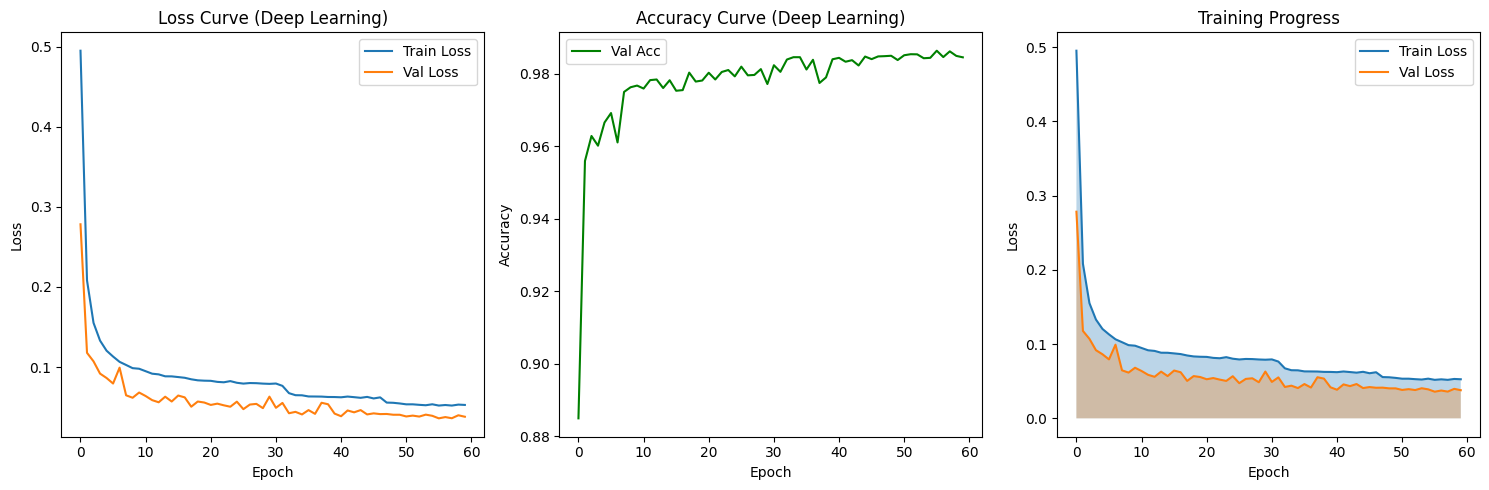

In [11]:
# 11. 训练曲线可视化
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss Curve (Deep Learning)")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,3,2)
plt.plot(val_accuracies, label='Val Acc', color='green')
plt.legend()
plt.title("Accuracy Curve (Deep Learning)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.subplot(1,3,3)
epochs_range = range(len(train_losses))
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.fill_between(epochs_range, train_losses, alpha=0.3)
plt.fill_between(epochs_range, val_losses, alpha=0.3)
plt.legend()
plt.title("Training Progress")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.tight_layout()
plt.show()

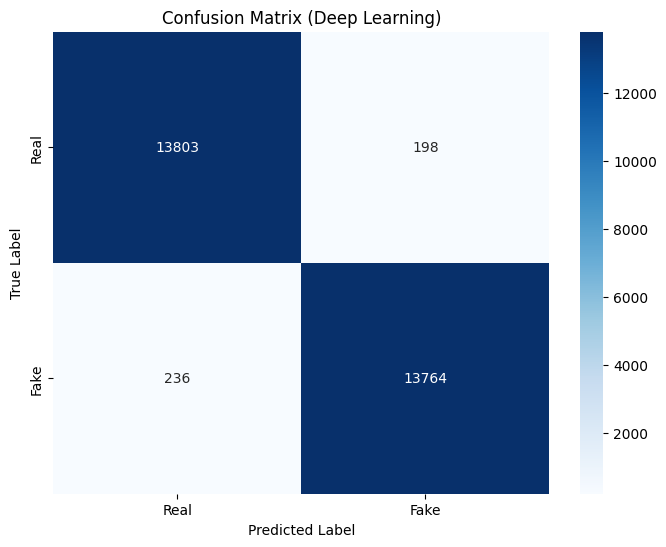


深度学习训练完成！
              precision    recall  f1-score   support

        Real       0.98      0.99      0.98     14001
        Fake       0.99      0.98      0.98     14000

    accuracy                           0.98     28001
   macro avg       0.98      0.98      0.98     28001
weighted avg       0.98      0.98      0.98     28001



In [12]:
# 12. 混淆矩阵 & 报告
plt.figure(figsize=(8,6))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix (Deep Learning)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

print("\n" + "="*50)
print("深度学习训练完成！")
print("="*50)
print(classification_report(all_labels, all_preds, target_names=classes))

In [13]:
# 13. 最终统计
print(f"\n📊 训练统计:")
print(f"总训练轮数: {len(train_losses)}")
print(f"最佳验证损失: {best_val_loss:.4f}")
print(f"最终验证准确率: {val_accuracies[-1]:.4f}")
print(f"最高验证准确率: {max(val_accuracies):.4f}")
print(f"模型保存路径: best_model_deep_learning.pth")


📊 训练统计:
总训练轮数: 60
最佳验证损失: 0.0359
最终验证准确率: 0.9845
最高验证准确率: 0.9863
模型保存路径: best_model_deep_learning.pth
